In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, MSELossWithCrop, Loss, MS_SSIMLoss, PerceptualLoss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
)

from data_utils import get_mouse_v1_data, PerSampleStoredDataset, append_syn_dataloaders

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

%env "WANDB_NOTEBOOK_NAME" "cnn_decoder.ipynb"
wandb.login()

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
env: "WANDB_NOTEBOOK_NAME"="cnn_decoder.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


True

In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # "device": "cpu",
    "seed": 0,
    # "crop_win": (slice(7, 29), slice(15, 51)),
    "crop_win": (22, 36),
    "wandb": None,
    # "wandb": {
    #     "project": "CSNG",
    #     "group": "sensorium_2022",
    # },
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()
config["data"]["syn_dataset_config"] = None

### Mouse V1 dataset (Sensorium 2022)

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        # "batch_size": 32,
        "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
})

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config)

Training dataset:	 22410 samples
Validation dataset:	 2523 samples
Test dataset:		 4977 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([3, 1, 36, 64])
  min=-1.699  max=2.017
  mean=0.162  std=0.914
responses:
  torch.Size([3, 8372])
  min=-0.000  max=21.945
  mean=0.327  std=1.026
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


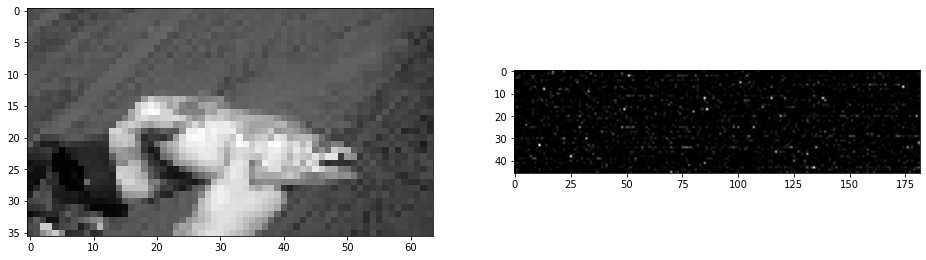

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["val"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if resp.shape[-1] % i == 0:
        reshape_to = (i, resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 3,
    "append_data_parts": ["train"],
    "data_key_prefix": "syn",
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(syn_stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if syn_resp.shape[-1] % i == 0:
        reshape_to = (i, syn_resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(syn_resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

## Encoder

In [ ]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
    pickle_module=dill,
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

## Compare decoders

In [8]:
def eval_decoder(model, dataloader, loss_fns, normalize_decoded, config):
    model.eval()
    val_losses = {loss_fn_name: {"total": 0} for loss_fn_name in loss_fns.keys()}
    denom_data_keys = {}
    n_batches = len(dataloader)

    for b in dataloader:
        ### combine from all data keys
        for data_key, stim, resp, neuron_coords, pupil_center in b:
            if model.__class__.__name__ == "InvertedEncoder":
                _, _, history = model(
                    resp_target=resp,
                    stim_target=stim,
                    additional_encoder_inp={
                        "data_key": data_key,
                    }
                )
                stim_pred = history["best"]["stim_pred"]
            elif model.core.__class__.__name__ == "L2O_Decoder":
                raise NotImplementedError("L2O_Decoder not implemented yet - data needs to be standardized")
                stim_pred, _ = model(
                    x=resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                    additional_core_inp=dict(
                        train=False,
                        stim=None,
                        resp=resp,
                        neuron_coords=neuron_coords,
                        pupil_center=pupil_center,
                        data_key=data_key,
                        n_steps=config["decoder"]["n_steps"],
                        x_hat_history_iters=None,
                    ),
                )
            else:
                stim_pred = model(
                    resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                )

            if normalize_decoded:
                stim_pred = normalize(stim_pred)

            for loss_fn_name, loss_fn in loss_fns.items():
                loss = loss_fn(stim_pred, stim, data_key=data_key, phase="val").item()
                # val_losses[loss_fn_name]["total"] += loss
                val_losses[loss_fn_name]["total"] += loss / len(b)
                val_losses[loss_fn_name][data_key] = loss if data_key not in val_losses[loss_fn_name] else val_losses[loss_fn_name][data_key] + loss

            denom_data_keys[data_key] = denom_data_keys[data_key] + 1 if data_key in denom_data_keys else 1

    for loss_name in val_losses:
        # val_losses[loss_name]["total"] /= n_batches * len(b)
        val_losses[loss_name]["total"] /= n_batches
        for k in denom_data_keys:
            val_losses[loss_name][k] /= denom_data_keys[k]

    return val_losses

In [9]:
### config for collecting results
runs_to_compare = {
    # "Inverted Encoder": {
    #     "decoder": InvertedEncoder(
    #         encoder=encoder,
    #         img_dims=stim.shape[1:],
    #         stim_pred_init="zeros",
    #         opter_cls=torch.optim.SGD,
    #         opter_config={"lr": 1000},
    #         n_steps=200,
    #         resp_loss_fn=F.mse_loss,
    #         stim_loss_fn=SSIMLoss(
    #             window=config["crop_win"],
    #             log_loss=True,
    #             inp_normalized=True,
    #             inp_standardized=False,
    #         ),
    #         img_gauss_blur_config=None,
    #         img_grad_gauss_blur_config={"kernel_size": 13, "sigma": 2},
    #         device=config["device"],
    #     ).to(config["device"]),
    #     "run_name": None
    # },

    # ### FCReadIn
    # "FCReadIn": {
    #     "run_name": "2024-02-25_17-09-59",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-25_17-09-59", "decoder.pt"),
    # },
    # "FCReadIn - Autoencoding": {
    #     "run_name": "2024-02-27_00-27-17",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_00-27-17", "decoder.pt"),
    # },
    # "FCReadIn - Contrastive reg.": {
    #     "run_name": "2024-02-28_21-27-46",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_21-27-46", "decoder.pt"),
    # },

    # ### ConvReadIn
    "ConvReadIn": {
        "run_name": "2024-02-25_21-16-59",
        "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-25_21-16-59", "decoder.pt"),
    },
    # "ConvReadIn - Autoencoding": {
    #     "run_name": "2024-02-27_13-01-15",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_13-01-15", "decoder.pt"),
    # },
    # "ConvReadIn - Contrastive reg.": {
    #     "run_name": "2024-02-27_00-04-30",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_00-04-30", "decoder.pt"),
    # },
    # "ConvReadIn - Fine-tuned": {
    #     "run_name": "2024-02-28_00-55-12",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_00-55-12", "decoder.pt"),
    # },
    # "ConvReadIn - From scratch": { # comparison to the above
    #     "run_name": "2024-02-28_00-59-51",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_00-59-51", "decoder.pt"),
    # },
    "ConvReadIn - Contrastive reg. + Fine-tuned": {
        "run_name": "2024-02-28_13-08-22",
        "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_13-08-22", "decoder.pt"),
    },

    # ### Single datasets
    # "ConvReadIn (mouse #1) - Fine-tuned": {
    #     "run_name": "2024-02-28_13-09-19",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_13-09-19", "decoder.pt"),
    # },
    # "ConvReadIn (mouse #1) - From scratch": {
    #     "run_name": "2024-02-28_15-10-47",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_15-10-47", "decoder.pt"),
    # },

    # "ConvReadIn (mouse #2) - Fine-tuned": {
    #     "run_name": "2024-02-28_17-20-42",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_17-20-42", "decoder.pt"),
    # },
    # "ConvReadIn (mouse #2) - From scratch": {
    #     "run_name": "2024-02-28_19-46-10",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_19-46-10", "decoder.pt"),
    # },

    # "ConvReadIn (mouse #3) - Fine-tuned": {
    #     "run_name": "2024-02-29_00-57-59",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-29_00-57-59", "decoder.pt"),
    # },
    # "ConvReadIn (mouse #3) - From scratch": {
    #     "run_name": "2024-02-29_10-35-56",
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-29_10-35-56", "decoder.pt"),
    # },
}

loss_fns = {
    "Log SSIM Loss": SSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
    ),
    "SSIM Loss": SSIMLoss(
        window=config["crop_win"],
        log_loss=False,
        inp_normalized=True,
        inp_standardized=False,
    ),
    # "Log SSIM Loss (win_size=5)": SSIMLoss(
    #     window=config["crop_win"],
    #     log_loss=True,
    #     inp_normalized=True,
    #     inp_standardized=False,
    #     win_size=5,
    # ),
    # "Log SSIM Loss (win_size=7)": SSIMLoss(
    #     window=config["crop_win"],
    #     log_loss=True,
    #     inp_normalized=True,
    #     inp_standardized=False,
    #     win_size=7,
    # ),
    # "Perceptual Loss": PerceptualLoss(
    #     window=config["crop_win"],
    #     inp_standardized=False,
    #     resize=True,
    # ),
    "MSE Loss": lambda x_hat, x: F.mse_loss(
        standardize(crop(x_hat, config["crop_win"])),
        standardize(crop(x, config["crop_win"]))
    ),
}
for k in loss_fns.keys():
    loss_fns[k] = Loss(
        model=None,
        config={
            "loss_fn": loss_fns[k],
            "l1_reg_mul": 0,
            "l2_reg_mul": 0,
            "con_reg_mul": 0,
        }
    )


[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.


In [10]:
### load models
for k in runs_to_compare.keys():
    run_dict = runs_to_compare[k]
    run_name = run_dict["run_name"]

    if "decoder" in run_dict and run_dict["decoder"] is not None:
        print(f"Using {k} model from run_dict...")
        decoder = run_dict["decoder"]
        ckpt = None
    else:
        print(f"Loading {k} model from ckpt (run name: {run_name})...")
        ### load ckpt and init
        ckpt = torch.load(run_dict["ckpt_path"], map_location=config["device"], pickle_module=dill)
        ckpt_config = ckpt["config"]
        decoder = MultiReadIn(**ckpt_config["decoder"]["model"]).to(config["device"])
        if "(ep" in k:
            decoder.load_state_dict(ckpt["decoder"])
        else:
            decoder.load_state_dict(ckpt["best"]["model"])
        decoder.eval()

    ### eval
    dls, neuron_coords = get_mouse_v1_data(config=config)
    if "syn_dataset_config" in config["data"] and config["data"]["syn_dataset_config"] is not None:
        dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"])
    test_losses = eval_decoder(
        model=decoder,
        dataloader=dls["mouse_v1"]["test"],
        loss_fns=loss_fns,
        # normalize_decoded=True if "l2o" in k.lower() else False,
        normalize_decoded=False,
        config=config,
    )

    ### save
    runs_to_compare[k]["test_losses"] = test_losses
    runs_to_compare[k]["config"] = config
    if ckpt is not None:
        runs_to_compare[k]["history"] = ckpt["history"]
        runs_to_compare[k]["best_val_loss"] = ckpt["best"]["val_loss"]
        for metric in ckpt["history"].keys():
            runs_to_compare[k][metric] = ckpt["history"][metric]

Loading ConvReadIn model from ckpt (run name: 2024-02-25_21-16-59)...
[WARNING] resp_shape in core_config will be overwritten by the output of the last readin layer (shape 144)
Loading ConvReadIn - Contrastive reg. + Fine-tuned model from ckpt (run name: 2024-02-28_13-08-22)...
[WARNING] resp_shape in core_config will be overwritten by the output of the last readin layer (shape 144)


In [ ]:
### plot losses together

### config
to_plot = "val_loss"
conv_win = 10

### plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for k, run_dict in runs_to_compare.items():
    if conv_win is not None and np.nan not in run_dict[to_plot]:
        vals_to_plot = np.convolve(run_dict[to_plot], np.ones(conv_win) / conv_win, mode="valid")
    else:
        vals_to_plot = run_dict[to_plot]
    ax.plot(
        [t for t in range(len(vals_to_plot)) if vals_to_plot[t] is not np.nan],
        [v for v in vals_to_plot if v is not np.nan],
        label=k,
        linewidth=3,
    )

if to_plot == "train_loss":
    ax.set_title("Training log SSIM loss", fontsize=16, pad=20)
elif to_plot == "val_loss":
    ax.set_title("Validation log SSIM loss", fontsize=16, pad=20)
else:
    raise ValueError(f"Unknown loss type: {to_plot}")

ax.set_xlabel("Epoch", fontsize=15, labelpad=20)
ax.set_ylabel("Log SSIM loss", fontsize=15, labelpad=20)
# ax.set_ylim(1.25, None)
# ax.set_ylim(1.3, 1.75)
# ax.set_xlim(0, 80)
ax.legend(
    loc="upper right",
    # loc="upper center",
    # loc="lower left",
    # loc="lower center",
    fontsize=14,
    frameon=False,
    # bbox_to_anchor=(0.6, 0.85),
    bbox_transform=ax.transAxes,
    # title="",
    title_fontsize=15,
    ncol=1,
)
# increase width of legend lines
leg = ax.get_legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)


# set larger font for x and y ticks
ax.tick_params(axis="both", which="major", labelsize=14)

# remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [12]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height.
    https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 10),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=14,
            rotation=90,
        )

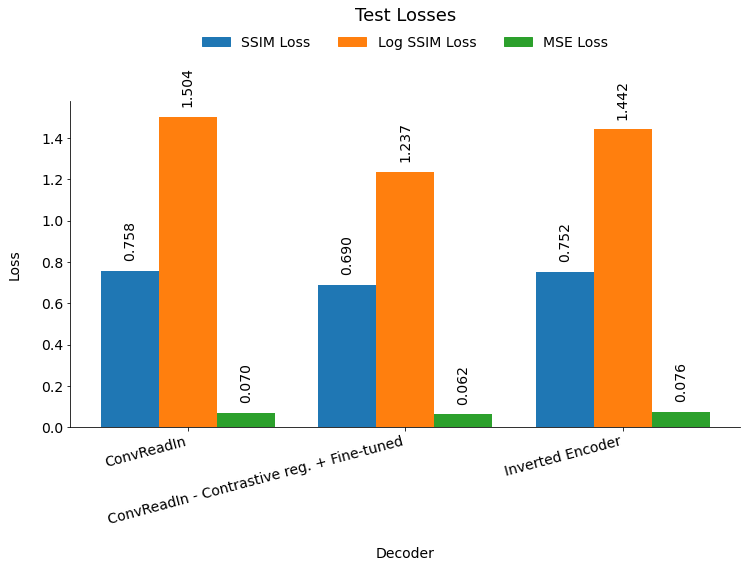

In [16]:
### bar plot of test losses
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

### grouped bar plot (run_dict["test_losses"] is a dict containing multiple losses)
bar_width = 0.8
losses_to_plot = [
    "SSIM Loss",
    "Log SSIM Loss",
    # "Log SSIM Loss (win_size=5)",
    # "Log SSIM Loss (win_size=7)",
    "MSE Loss",
]
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
]
for i, (k, run_dict) in enumerate(runs_to_compare.items()):
    for j, loss in enumerate(losses_to_plot):
        rects = ax.bar(
            i - bar_width / len(losses_to_plot) + j * bar_width / len(losses_to_plot),
            run_dict["test_losses"][loss]["total"],
            width=bar_width / len(losses_to_plot),
            color=colors[j],
        )
        autolabel(rects)

### add legend with color explanation
from matplotlib import patches as mpatches
ax.legend(
    handles=[
        mpatches.Patch(color=colors[i], label=loss)
        for i, loss in enumerate(losses_to_plot)
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.24),
    ncol=len(losses_to_plot),
    fontsize=14,
    frameon=False,
)

ax.set_title(
    "Test Losses",
    fontsize=18,
    pad=80,
)
ax.set_xticks(range(len(runs_to_compare)))
ax.set_xticklabels(runs_to_compare.keys())
### with rotatation of the xtick labels
# ax.set_xticklabels(
#     [k for k in runs_to_compare.keys()],
#     rotation=15,
#     ha="right",
# )
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_xlabel("Decoder", fontsize=14, labelpad=20)
ax.set_ylabel("Loss", fontsize=14, labelpad=20)
ax.set_ylim(0, None)

# remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()